# MNIST with Fast AI

In this notebook, I will attempt to replicate all the steps in Chapter 4 of the book 'Deep Learning for Coders with fastai and PyTorch for the full MNIST dataset.

In [144]:
from fastai2.vision.all import *
from utils import *

In [70]:
matplotlib.rc('image',cmap='Greys')

## Data

In [145]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

We will view one sample image for each of the 10 classes.

In [146]:
training_paths = (path/'training').ls().sorted()

In [147]:
training_paths

(#10) [Path('/storage/data/mnist_png/training/0'),Path('/storage/data/mnist_png/training/1'),Path('/storage/data/mnist_png/training/2'),Path('/storage/data/mnist_png/training/3'),Path('/storage/data/mnist_png/training/4'),Path('/storage/data/mnist_png/training/5'),Path('/storage/data/mnist_png/training/6'),Path('/storage/data/mnist_png/training/7'),Path('/storage/data/mnist_png/training/8'),Path('/storage/data/mnist_png/training/9')]

In [74]:
sample_images = [path.ls()[0] for path in training_paths] 

In [75]:
for img in sample_images: display(Image.open(img))

## Pixel Similarity Approach

In [148]:
import random
train_split = 0.8 # train_test_dplit
frac_images = 1 # Fraction of images to use
image_names = [path.ls() for path in training_paths]
[random.shuffle(image_name) for image_name in image_names] #shuffle images in each folder
train_image_names = [image_name[:int(len(image_name)*frac_images*train_split)] for image_name in image_names]
valid_image_names = [image_name[int(len(image_name)*frac_images*train_split):int(len(image_name)*frac_images)] for image_name in image_names]
#Number of images of each type is given 
n_train_images = [len(image_name) for image_name in train_image_names]
n_valid_images = [len(image_name) for image_name in valid_image_names]

In [77]:
n_train_images

[4738, 5393, 4766, 4904, 4673, 4336, 4734, 5012, 4680, 4759]

Now convert image of each digit into a tensor and stack the tensors to get a single stacked tensor for each digit

In [149]:
#Convert each image into a tensor 
train_tensors = [list(map(lambda x: tensor(Image.open(x)),image_name)) for image_name in train_image_names]
valid_tensors = [list(map(lambda x: tensor(Image.open(x)),image_name)) for image_name in valid_image_names]
#Now stack the tensors
train_tensors = [torch.stack(digit_tensor).float()/255 for digit_tensor in train_tensors]
valid_tensors = [torch.stack(digit_tensor).float()/255 for digit_tensor in valid_tensors]

As expected 10 train and valid tensors are created , with each tensor of dimensions m_imagesx28x28

In [79]:
len(train_tensors),train_tensors[0].shape,len(valid_tensors),valid_tensors[0].shape

(10, torch.Size([4738, 28, 28]), 10, torch.Size([1185, 28, 28]))

We will also create target labels for each of these training examples

In [150]:
train_y = torch.cat([tensor([i]*n_images) for (i,n_images) in enumerate(n_train_images)])
valid_y = torch.cat([tensor([i]*n_images) for (i,n_images) in enumerate(n_valid_images)])

In [151]:
train_y = train_y.unsqueeze(1) # To ensure correct shape of tensor
valid_y = valid_y.unsqueeze(1)
train_y.shape,valid_y.shape

(torch.Size([47995, 1]), torch.Size([12005, 1]))

Now we can compute the mean of each tensor across the first dimension

In [82]:
digit_means = [t.mean(0) for t in train_tensors]

As expected the length of the list is again equal to 10, and the shape of each tensor is 28x28

In [83]:
len(digit_means),digit_means[0].shape

(10, torch.Size([28, 28]))

We can now visualize the image of the 'average' digit for each of the 10 digits

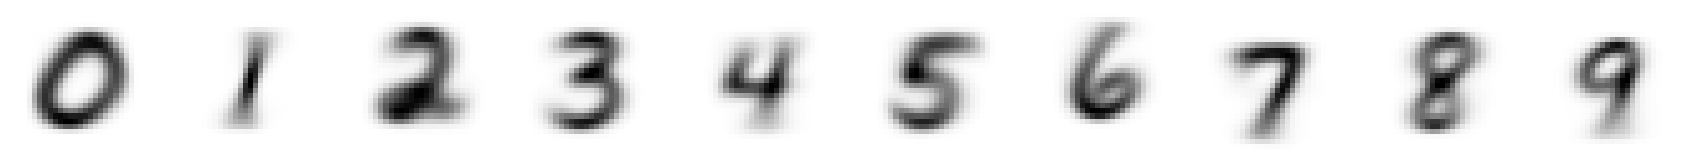

In [84]:
show_images(digit_means)

The below function return the L1 distance for each image from the given mean image

In [85]:
def mnist_distance(inputs,means):
    '''
    Arguments:
        inputs: Tensor of shape Nx28x28
        mean: mean tensor of shape 10*28x28
    Outputs: 
        Tensor of shape Nx10"
    '''
    distances = [(inputs - m).abs().mean((-1,-2)) for m in means] 
    return torch.stack(distances).transpose(0,1)

In [86]:
def predict(distances):
    '''
    Arguments:
        distances: Nx10 distance matrix
    Output:
        prediction corresponding to the lowest distance; Tensore of size N
    '''
    return (distances.min(dim=1)[1]) 
    

Using these two functions, we can get the predictions for the validations set. Note that the true label for each input is the index of the parent list

In [87]:
valid_predictions = [predict(mnist_distance(valid_input,digit_means)) for valid_input in valid_tensors]

In [88]:
len(valid_predictions)

10

In [89]:
accuracy = np.array([(prediction==i).float().mean().item() for (i,prediction) in enumerate(valid_predictions)])

The classwise accuracy of the model is as follows

In [90]:
for i in range(10):
    print("{}:{:.4f}".format(i,accuracy[i]))

0:0.8245
1:0.9993
2:0.4077
3:0.6161
4:0.6732
5:0.3060
6:0.7475
7:0.7757
8:0.4082
9:0.6924


In [91]:
print("The  overall accuracy of the baseline model is equal to {:.4f}".format(accuracy.mean()))

The  overall accuracy of the baseline model is equal to 0.6451


## Linear Model

In this section, a simple linear model is created to classify the digits. The simple linear model will just have an input layer with 784 units corresponding to each pixel and an output layer with 10 units corresonding to each image class.

We first define a function to intialise the weights and bias terms of the model that can be optimized iteratively.

In [92]:
def init_params(size,std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,10))
bias = init_params(1)

The linear model is defined as shown below

In [93]:
def linear_model(xb):
    return xb@weights + bias

The softmax function defined below, takes a list of values and normalizes it so that each value is between 0 and 1.

In [94]:
def softmax(inputs):
    exps = torch.exp(inputs.float())
    return exps/exps.sum()

The loss function is the cross entropy loss which is the appropriate loss function for multi class classification

In [160]:
def cross_entropy_loss(inputs,targets): 
    inputs = inputs.softmax(dim=1)
    return -(inputs[range(len(inputs)),targets]).log().mean()

Now we can create the equivalent of a Dataset in Pytorch that return a tuple of the form (x,y).First we stack all the tensors into a single tensors

In [152]:
train_x = torch.cat(train_tensors).view(-1,28*28)
valid_x = torch.cat(valid_tensors).view(-1,28*28)
train_x.shape,train_y.shape,valid_x.shape,valid_y.shape

(torch.Size([47995, 784]),
 torch.Size([47995, 1]),
 torch.Size([12005, 784]),
 torch.Size([12005, 1]))

Now create a dataset

In [153]:
train_dset = list(zip(train_x,train_y))

In [98]:
x,y = train_dset[0]
x.shape,y

(torch.Size([784]), tensor([0]))

We can now create a Pytorch dataloader with this dataset

In [154]:
train_dl = DataLoader(train_dset,batch_size =256)
xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Also create a data loader for the validation set

In [155]:
valid_dset  = list(zip(valid_x,valid_y))
valid_dl = DataLoader(valid_dset,batch_size = 256)

In [101]:
train_x.shape,weights.shape

(torch.Size([47995, 784]), torch.Size([784, 10]))

### Sample run 

Below we step through the training process with a sample batch

In [102]:
batch,labels = first(train_dl)
batch.shape,labels.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [103]:
preds = linear_model(batch)
preds.shape

torch.Size([256, 10])

In [104]:
loss = cross_entropy_loss(preds,labels)
loss

tensor(10.8375, grad_fn=<NegBackward>)

In [105]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 10]), tensor(-3.6493e-10), tensor([-1.1176e-08]))

Carry out one step of gradient descent

In [106]:
lr = 1e-3
weights.data -= lr * weights.grad
bias.data -= lr * bias.grad

See if loss reduced

In [107]:
preds = linear_model(batch)
cross_entropy_loss(preds,labels)

tensor(10.7605, grad_fn=<NegBackward>)

In [108]:
weights.grad = None
bias.grad = None

Now we can put the above steps into a single function

In [109]:
def calc_grad(xb,yb,model):
    preds = model(xb)
    loss = cross_entropy_loss(preds,yb)
    loss.backward()

Check if this works

In [110]:
calc_grad(batch,labels,linear_model)
weights.grad.mean(),bias.grad

(tensor(-1.8246e-10), tensor([-1.8626e-09]))

And write a function to carry out model training for one epoch

In [158]:
def train_epoch(model,lr,params):
    for xb,yb in train_dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

Now we also write a function to calculate validation accuracy for a batch.

In [159]:
def batch_accuracy(preds,yb):
    predictions = preds.max(dim=1)[1].unsqueeze(1)
    yb = yb.squeeze()
    return (predictions==yb).float().mean()

We can now create a function to calculate the accuracy for each epoch

In [113]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb),yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

In [114]:
validate_epoch(linear_model)

0.1053

Now examine if accuracy improves by training for one epoch

In [115]:
lr = 0.1
params = weights,bias
train_epoch(linear_model,lr,params)
validate_epoch(linear_model)

0.1859

Try running for multiple epochs

In [116]:
for i in range(20):
    train_epoch(linear_model,lr,params)
    print(validate_epoch(linear_model),end = ' ')

0.2785 0.3548 0.4105 0.4512 0.4807 0.5047 0.5239 0.5398 0.5513 0.563 0.5727 0.5799 0.5856 0.5901 0.5946 0.598 0.602 0.606 0.6091 0.6106 

### Creating an Optimizer

In [117]:
linear_model2 = nn.Linear(28*28,10)
w,b = linear_model2.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [118]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
    def step(self,*args,**kwargs):
        for p in self.params: p.data -= p.grad.data *self.lr
    def zero_grad(self,*args,**kwargs):
        for p in self.params: p.grad = None

In [119]:
lr = 0.1
opt = BasicOptim(linear_model2.parameters(),lr)

Updated training loop is now given by

In [120]:
def train_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

In [121]:
validate_epoch(linear_model2)

0.1082

In [122]:
def train_model(model,epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end= ' ')

In [123]:
train_model(linear_model2,20)

0.1011 0.1834 0.2842 0.3441 0.3866 0.4137 0.4381 0.4557 0.4715 0.4824 0.4917 0.5005 0.5081 0.5146 0.5206 0.5251 0.5296 0.5334 0.5379 0.5412 

Now using the SGD optimizer provided by fast ai

In [124]:
linear_model3 = nn.Linear(28*28,10)
opt = SGD(linear_model3.parameters(),lr=0.1)
train_model(linear_model3,20)

0.1011 0.1784 0.2805 0.344 0.3854 0.4135 0.4375 0.4545 0.4699 0.4829 0.4908 0.4981 0.5056 0.5131 0.5184 0.5241 0.5281 0.5337 0.5382 0.5417 

Now create a DataLoaders class by passing in both the training and valdiation sets

In [156]:
dls = DataLoaders(train_dl,valid_dl)

Now we can use the Learner class to avoid writing any boiler plate

In [161]:
learn = Learner(dls,nn.Linear(28*28,10),opt_func = SGD,
                loss_func = cross_entropy_loss, metrics = batch_accuracy)

In [127]:
learn.fit(10,lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.367332,4.238232,0.099125,00:05
1,0.281678,3.116744,0.167177,00:03
2,0.259381,2.690326,0.276394,00:05
3,0.251433,2.460329,0.340662,00:04
4,0.247416,2.311152,0.384212,00:05
5,0.245038,2.203323,0.411633,00:04
6,0.243515,2.120255,0.435468,00:04
7,0.242472,2.053680,0.454908,00:08
8,0.241703,1.998873,0.469478,00:06
9,0.241097,1.952861,0.481165,00:03


### Adding a Non Linearity

In [162]:
simple_net = nn.Sequential(
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,10))

In [163]:
learn = Learner(dls,simple_net,opt_func=SGD,loss_func=cross_entropy_loss,metrics=batch_accuracy)

In [164]:
learn.fit(40,0.01)

epoch,train_loss,valid_loss,batch_accuracy,time
0,1.752031,2.590733,0.099125,00:05
1,1.216744,2.557050,0.100554,00:06
2,0.899474,2.280073,0.215216,00:05
3,0.736832,2.078324,0.312774,00:04
4,0.646674,1.946730,0.356592,00:05
5,0.590854,1.852450,0.383172,00:05
6,0.552992,1.778626,0.404523,00:04
7,0.525687,1.717293,0.424119,00:05
8,0.505122,1.664572,0.443226,00:04
9,0.488980,1.618474,0.464506,00:04


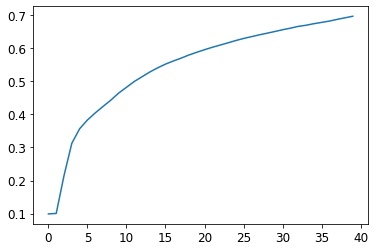

In [165]:
plt.plot(L(learn.recorder.values).itemgot(2))

The final accuracy is given below

In [166]:
learn.recorder.values[-1][2]

0.6968408226966858

Now use the resnet model architecture with the fast AI learner

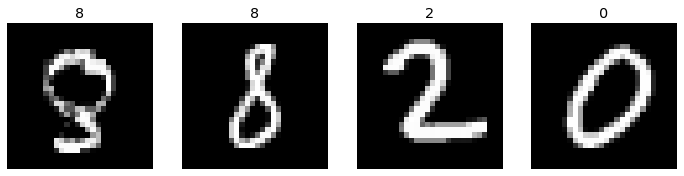

In [167]:
dls = ImageDataLoaders.from_folder(path,valid_pct=0.2)
dls.valid.show_batch(max_n=4,nrows=1)

In [168]:
learn = cnn_learner(dls,resnet18,pretrained=False,loss_func=F.cross_entropy,metrics=accuracy)

In [169]:
learn.fit_one_cycle(1,0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.097582,0.056914,0.984071,00:51


## Learner Class

This is my own implementation of the learner class

In [98]:
class MyLearner(object):
    def __init__(self,dls,model,opt_func,loss_func,metrics):
        self.dls = dls
        self.model = model
        self.opt_func = opt_func
        self.loss_func = loss_func
        self.metrics= metrics
    
    def calc_grad(self,xb,yb):
        preds = self.model(xb)
        loss = self.loss_func(preds,yb)
        loss.backward()

    
    def train_epoch(self,opt):
        for xb,yb in self.dls.train:
            self.calc_grad(xb,yb)
            opt.step()
            opt.zero_grad()
    
    def validate_epoch(self,model):
        m = [self.metrics(self.model(xb),yb) for xb,yb in self.dls.valid]
        return round(torch.stack(m).mean().item(),4)
    
    def fit(self,n_epochs,lr):
        opt = self.create_optimizer(lr)
        for i in range(n_epochs):
            self.train_epoch(opt)
            print(self.validate_epoch(self.model), end= ' ')
    
    def create_optimizer(self,lr):
        return self.opt_func(self.model.parameters(),lr)

In [99]:
dls = DataLoaders(train_dl,valid_dl)

In [100]:
my_learn = MyLearner(dls,nn.Linear(28*28,10),SGD,cross_entropy_loss,batch_accuracy)

In [102]:
my_learn.fit(5,lr=0.1)

0.237 0.3283 0.3803 0.4098 0.4278 